In [87]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score,recall_score
from sklearn.model_selection import GridSearchCV


In [88]:
# Download latest version
dataset_dir = kagglehub.dataset_download("mssmartypants/water-quality")
print("Path to dataset files:", dataset_dir)
# Find the CSV file within the downloaded directory
for filename in os.listdir(dataset_dir):
  if filename.endswith(".csv"):
    filepath = os.path.join(dataset_dir, filename)
    break

Path to dataset files: /root/.cache/kagglehub/datasets/mssmartypants/water-quality/versions/3


In [89]:
# Load the dataset into a DataFrame
df = pd.read_csv(filepath)
# Display all attributes and a target of dataframe
df

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,0.05,7.78,0.00,1.95,0.040,0.10,0.03,0.03,1.37,0.00,...,0.197,14.29,1.00,0.005,3.57,2.13,0.09,0.06,0.03,1
7995,0.05,24.22,0.02,0.59,0.010,0.45,0.02,0.02,1.48,0.00,...,0.031,10.27,1.00,0.001,1.48,1.11,0.09,0.10,0.08,1
7996,0.09,6.85,0.00,0.61,0.030,0.05,0.05,0.02,0.91,0.00,...,0.182,15.92,1.00,0.000,1.35,4.84,0.00,0.04,0.05,1
7997,0.01,10,0.01,2.00,0.000,2.00,0.00,0.09,0.00,0.00,...,0.000,0.00,0.00,0.000,0.00,0.00,0.00,0.00,0.00,1


In [90]:
df['is_safe'].value_counts()

,count
is_safe,
0,7084
1,912
#NUM!,3


1. ควรใช้โมเดลจําแนกแบบใดที่ได้ความแม่นยําสูงสุด (Accuracy, F1-score, etc.)
เพื่อใช้ในเชิงปฏิบัติการ โดย
พิจารณาตัวแปรต้นวิเคราะห์ 19 สารปนเปื้อน เพื่อทํานายว่าน้ําที่ตรวจสอบนั้นปลอดภัยต่อการจายให้ภาคครัวเรือน
หรือไม่ (คะแนน 8%)

In [91]:
# Display types of all attributes and a target of dataframe
df.info()
###################################
# Data wrangling and pre-processing
X = df.drop('is_safe', axis=1) # Define X before using it
X = X.replace('#NUM!', pd.NA)
df = pd.concat([X, df['is_safe']], axis=1).dropna() # Concatenate X and y and drop rows with any NaNs
X = df.drop('is_safe', axis=1)
y = df['is_safe']



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [92]:
# check for class sample --> if there is over-sampling
y.value_counts()

,count
is_safe,
0,7084
1,912


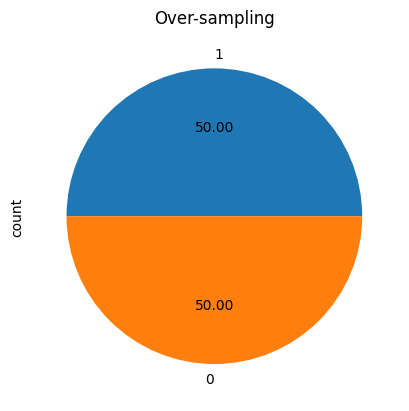

In [93]:
#Random Oversampling
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority") # String
X = df.drop(['is_safe'], axis=1)
y = df['is_safe']
X, y = ros.fit_resample(X, y)

ax = y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [94]:
# # check for class sample --> after solve for over-sampling
y.value_counts()

,count
is_safe,
1,7084
0,7084


In [95]:
# Split the data ...
# *** test_size=0.2, random_state=42 for training/testing set only!!! ***
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [96]:
X_train

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
10581,0.36,11.11,0.03,1.96,0.008,2.96,0.33,0.54,0.72,0.00,0.000,0.028,18.72,1.56,0.006,22.59,2.17,0.01,0.20,0.09
12222,0.05,28.38,0.04,1.25,0.006,5.09,0.05,1.33,1.29,0.43,0.006,0.108,9.01,1.84,0.004,23.76,2.12,0.07,0.07,0.01
11688,0.09,21.12,0.04,0.61,0.005,1.99,0.25,0.83,1.09,0.34,0.005,0.084,5.88,1.46,0.001,27.44,4.60,0.06,0.04,0.01
11349,0.61,2.41,0.03,0.59,0.002,1.94,0.77,1.54,0.62,0.23,0.001,0.017,1.99,1.08,0.007,11.16,0.98,0.01,0.47,0.03
3275,0.19,23.09,0.65,1.31,0.020,4.11,0.16,1.34,0.36,0.84,0.840,0.070,9.12,1.31,0.007,30.79,4.78,0.09,0.09,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0.04,17.85,0.02,0.84,0.010,0.02,0.01,1.44,1.42,0.00,0.007,0.177,0.91,0.75,0.002,3.27,1.16,0.06,0.06,0.06
13418,0.85,10.38,0.05,0.17,0.006,7.52,0.89,0.52,0.32,0.31,0.002,0.110,3.55,1.79,0.000,6.24,4.15,0.01,0.10,0.02
5390,0.07,3.24,0.03,2.97,0.000,0.26,0.07,0.49,1.38,0.00,0.009,0.115,19.11,1.73,0.005,1.65,0.67,0.08,0.07,0.08
860,2.16,14.73,0.01,2.63,0.009,1.02,0.29,0.76,0.47,0.00,0.000,0.175,12.61,1.12,0.005,26.80,4.45,0.07,0.19,0.07


In [97]:
# Tranform data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [98]:
# declare parameters for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.869 total time=   4.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.920 total time=   3.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.868 total time=   3.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.970 total time=   4.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.917 total time=   3.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.897 total time=   2.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.889 total time=   2.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.902 total time=   2.7s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.902 total time=   2.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.900 total time=   2.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.806 total time=   2.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=3)

In [99]:
print("Best hyperparameters is:", grid.best_params_)

Best hyperparameters is: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [100]:
# ใช้โมเดล Support Vector Classification โดยใช้ parameter ที่ได้จากทํา hyper parameter tuning
classifier = SVC(kernel = 'rbf', gamma = 1 , C = 100)
classifier.fit(X_train, y_train)

SVC(C=100, gamma=1)

In [101]:
SVM_pred =classifier.predict(X_test)

In [102]:
# Confusion Matrix and Evalution matrix
from sklearn.metrics import confusion_matrix
SVM_acc = accuracy_score(y_test, SVM_pred)
print('Accuracy is: ',SVM_acc)
print('Misclassification Rate',1 - metrics.accuracy_score(y_test, SVM_pred))
cm = confusion_matrix(y_test, SVM_pred)
cm
print(classification_report(y_test,SVM_pred))

Accuracy is:  0.9880028228652082
Misclassification Rate 0.011997177134791759
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1420
           1       0.98      1.00      0.99      1414

    accuracy                           0.99      2834
   macro avg       0.99      0.99      0.99      2834
weighted avg       0.99      0.99      0.99      2834



2. สมมติว่านํ้าที่ทําการกรองและผลิตออกมานั้นวัดคาด้วยเครื่องมือวัดและได้ปริมาณสารปนเปื้อนดังข้างใต้ น้ําที่ผลิต
ได้นั้นปลอดภัยหรือไม่ จงใช้โมเดลที่เรียนรู้มาเป็นตัวทํานาย (คะแนน 2%)
 --> bacteria = 0.5 (ค่าอื่น ๆ วัดได้ที่0)

In [103]:
new_x_test = df.iloc[0].drop('is_safe')
new_x_test[:] = 0
new_x_test['bacteria'] = 0.5
new_x_test = np.array(new_x_test.tolist())
new_x_test

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [104]:
new_x_test = new_x_test.reshape(1, -1)
new_x_test

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [105]:
new_x_text = sc.transform(new_x_test)
new_x_test

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [106]:
SVM_pred =classifier.predict(new_x_test)
print(f"ผลลัพธ์การทํานาย: {SVM_pred[0]}")
print("น้ํายังปนเปื้อนมากเกินเกณฑ์ --> ไม่ปลอดภัย")

ผลลัพธ์การทํานาย: 0
น้ํายังปนเปื้อนมากเกินเกณฑ์ --> ไม่ปลอดภัย
